In [1]:
using Gridap, Gridap.Geometry, Gridap.Fields
using Gmsh, GridapGmsh
using GLMakie, DelimitedFiles, Interpolations
using LinearAlgebra, SparseArrays, KrylovKit
using ChainRulesCore, Zygote
using PartitionedArrays
using NLopt
using GridapMakie

import Gridap.CellData: Interpolable
import ChainRulesCore: rrule
import Gmsh: gmsh


include("Materials/Materials.jl")
include("Module/Mesh_Periodic.jl")
include("Module/Helper.jl")
include("Module/GridapFE.jl")
include("Module/Control.jl")
include("Module/Model.jl")
include("Module/Objective.jl")

g0_p (generic function with 2 methods)

In [11]:
# Geometry parameters of the mesh
L = 150           # Length of the normal region  
hair = 500        # Height of the air region
hs = 300          # Height of the source location in air
ht = 200          # Height of the target location in air
hd = 200          # Height of design domain
hsub = 100        # Height of substrate domain below design domain
dpml = 100        # Thickness of the PML

# Characteristic length (controls the resolution, smaller the finer)
resol = 20        # Number of points per wavelength
l1 = L/resol      # Air
l2 = l1/2.0       # Design domain
l3 = l1           # PML

meshfile = "geometry.msh"
geo_param = PeriodicGeometry(L, hair, hs, ht, hd, hsub, dpml, l1, l2, l3)
# MeshGenerator(geo_param, meshfile)


Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

In [12]:
############  Optimization parameters #############
flag_f = true       # Turn on filter
flag_t = true       # Turn on threshold

# Filter and threshold paramters
r = [0.02 * L, 0.02 * L]  # Filter radius
β = 80.0                  # β∈[1,∞], threshold sharpness
η = 0.5                   # η∈[0,1], threshold center

α = 0.0 / (2 * 1000.0)    # Equivalent loss α = 1/2Q

# Number of subspace
K = 20

# Amplify g for NLopt
Amp = 1

# Sum over kx
nkx = 30
nparts = nkx / 2

Bp = true          # Matrix B depend on parameters?
pv = 1

# Foundary constraint parameters
c = 0#resol^4
lw = r[1]
ls = r[1]
ηe = fηe(lw / r[1])
ηd = fηd(lw / r[1])

control = ControllingParameters(flag_f, flag_t, r, β, η, α, nparts, nkx, K, Amp, Bp, pv, c, ηe, ηd)

gridap = GridapFE(meshfile, 1, 2, ["DirichletEdges", "DirichletNodes"], ["DesignNodes", "DesignEdges"], ["Target"], ["Source"], flag_f)

#phys = PhysicalParameters(k, kb, ω, ϵ1, ϵ2, ϵ3, ϵd, μ, R, σs, dpml, LHp, LHn, wg_center, wg_size)


Info    : Reading 'geometry.msh'...
Info    : 45 entities
Info    : 6325 nodes
Info    : 12418 elements
Info    : Done reading 'geometry.msh'


GridapParameters(UnconstrainedFESpace(), UnconstrainedFESpace(), UnconstrainedFESpace(), UnconstrainedFESpace(), UnconstrainedFESpace(), UnconstrainedFESpace(), 5046, UnstructuredGrid(), Measure(), Measure(), Measure(), Measure(), Measure(), GenericCellField(), Int8[8, 8, 8, 8, 8, 8, 8, 8, 8, 8  …  10, 10, 10, 10, 10, 10, 10, 10, 10, 10], 7)

In [13]:

material = "Gold"
n_λ, k_λ = RefractiveIndex(material)
λ1 = 532
λ2 = 549
nm1 = n_λ(λ1) + 1im * k_λ(λ1)
nm2 = n_λ(λ2) + 1im * k_λ(λ2)
nf = sqrt(1.77)
μ = 1
R = 1e-10
LHp=[Inf, hair + hd]  # Start of PML for x,y > 0
LHn=[Inf, hsub]       # Start of PML for x,y < 0


ω1 = 2 * π / λ1
phys1 = PhysicalParameters(ω1, nf, nm1, nm1, μ, R, dpml, LHp, LHn, hd)
ω2 = 2 * π / λ2
phys2 = PhysicalParameters(ω2, nf, nm2, nm2, μ, R, dpml, LHp, LHn, hd)


# kb = 0. * ω1
# p0 = zeros(gridap.np)
# p_vec = p_extend(p0; gridap)
# pf_vec = Filter(p_vec; control, gridap)
# pf_vec[pf_vec .< 0] .= 0
# pf_vec[pf_vec .> 1] .= 1.0
# pfh = FEFunction(gridap.FE_Pf, pf_vec)
# pth = (pf -> Threshold(pf; control)) ∘ pfh

# A1_mat = MatrixA(pth, kb; phys=phys1, control, gridap)

# btest(v) = ∫(v)gridap.dΓ_s
# b_vec = assemble_vector(btest, gridap.FE_V)

# u1_vec = A1_mat\b_vec
# u1h = FEFunction(gridap.FE_U, u1_vec)
# A2_mat = MatrixA(pth, kb; phys=phys2, control, gridap)
# o_vec = VectorO(1, 1; gridap)
# v2_vec = A2_mat' \ o_vec
# v2h = FEFunction(gridap.FE_U, v2_vec)

# fig, ax, plt = plot(gridap.Ω, real(u1h), colormap=:bwr)
# Colorbar(fig[1,2], plt)
# ax.aspect = AxisAspect(L/(phys1.LHn[2]+phys1.LHp[2]))
# limits!(ax, -L/2, L/2, -phys1.LHn[2], phys1.LHp[2])
# fig

PhysicalParameters(0.011444781980290685, 1.3304134695650072, 0.36320816326530625 + 2.677387755102041im, 0.36320816326530625 + 2.677387755102041im, 1.0, 1.0e-10, 100.0, [Inf, 700.0], [Inf, 100.0], 200.0)

In [6]:
p0 = rand(gridap.np)
δp = rand(gridap.np)*1e-8
grad = zeros(gridap.np)

kb = 0.0 * ω1
g0 = g0_p(p0, grad; kb, phys1, phys2, control, gridap)
g1 = g0_p(p0+δp, []; kb, phys1, phys2, control, gridap)
g1-g0, grad'*δp

(-0.0009285676569561474, -0.0009285677665944956)

In [7]:
function g0_p_optimize(p_init, TOL = 1e-4, MAX_ITER = 500; phys1, phys2, control, gridap)
    ##################### Optimize #################
    opt = Opt(:LD_MMA, gridap.np)
    lb = zeros(gridap.np)
    ub = ones(gridap.np)
    opt.lower_bounds = lb
    opt.upper_bounds = ub
    opt.ftol_rel = TOL
    opt.maxeval = MAX_ITER
    opt.max_objective = (p0, grad) -> g0_p(p0, grad; kb=0, phys1, phys2, control, gridap)
    if (length(p_init)==0)
        p_initial = readdlm("p_opt_value.txt", Float64)
        p_initial = p_initial[:]
    else
        p_initial = p_init[:]
    end
    if control.pv < 1
        inequality_constraint!(opt, (x, g) -> VolumeConstraint(x, g; control, gridap), 1e-2)
    end
    if control.c > 0
        equality_constraint!(opt, (x, g) -> LWConstraint(x, g; control, gridap), 1e-8)
    end

    (g_opt, p_opt, ret) = optimize(opt, p_initial)
    @show numevals = opt.numevals # the number of function evaluations
    
    return g_opt / control.Amp, p_opt
end

g0_p_optimize (generic function with 3 methods)

In [34]:
p_init = ones(gridap.np) * 0.7
β_list = [5.0, 10.0, 20.0, 30.0, 40.0, 60.0, 80.0]
# β_list = [80.0, 80.0, 80.0, 80.0, 80.0]

g_opt = 0
for bi = 7 : 7
    β = β_list[bi]
    control = ControllingParameters(flag_f, flag_t, r, β, η, α, nparts, nkx, K, Amp, Bp, pv, c, ηe, ηd)

    if bi == 1
        g_opt, p_opt = g0_p_optimize(p_init, 1e-6, 200; phys1, phys2, control, gridap)
    
    else
        g_opt, p_opt = g0_p_optimize([], 1e-12, 200; phys1, phys2, control, gridap)
    end
    if isfile("p_opt.value.txt")
        run(`rm p_opt_value.txt`)
    end
    open("p_opt_value.txt", "w") do iop
        for i = 1 : length(p_opt)
            p_temp = p_opt[i]
            write(iop, "$p_temp \n")
        end
    end
    open("g_opt_value.txt", "a") do io
        write(io, "$g_opt \n")
    end
end
@show g_opt

numevals = opt.numevals = 200
g_opt = 817970.210915811


817970.210915811

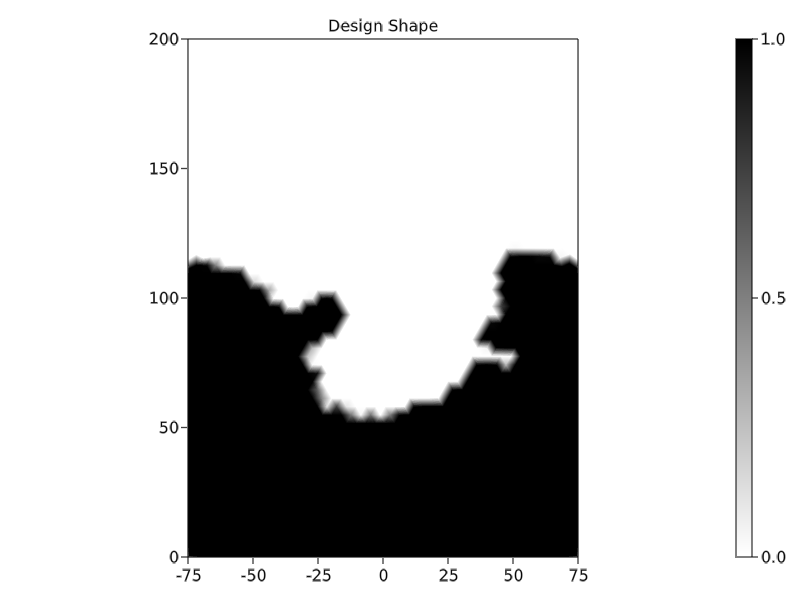

In [14]:
# Output and view
ImportFromFile = true
N = num_free_dofs(gridap.FE_U)
if ImportFromFile
    p_max = readdlm("p_opt_value.txt", Float64)
    p0 = p_max[:]
else
    p0 = zeros(gridap.np)
end

kb = 0
pf_vec = pf_p0(p0; control, gridap)
pfh = FEFunction(gridap.FE_Pf, pf_vec)
pth = (pf -> Threshold(pf; control)) ∘ pfh
A1_mat = MatrixA(pth, kb; phys=phys1, control, gridap)
b1_vec = assemble_vector(v->(∫(v)gridap.dΓ_s), gridap.FE_V)
u1_vec = A1_mat \ b1_vec
u1h = FEFunction(gridap.FE_U, u1_vec)

A2_mat = MatrixA(pth, kb; phys=phys2, control, gridap)
o_vec = VectorO(1, 1; gridap)
v2_vec = A2_mat' \ o_vec
v2h = FEFunction(gridap.FE_U, v2_vec)

fig, ax, plt = plot(gridap.Ω, pth, colormap = :binary)
Colorbar(fig[1,2], plt)
ax.aspect = AxisAspect(L/(hd))
ax.title = "Design Shape"
limits!(ax, -L/2, L/2, 0, hd)
#save("Results/shape.png", fig)
fig

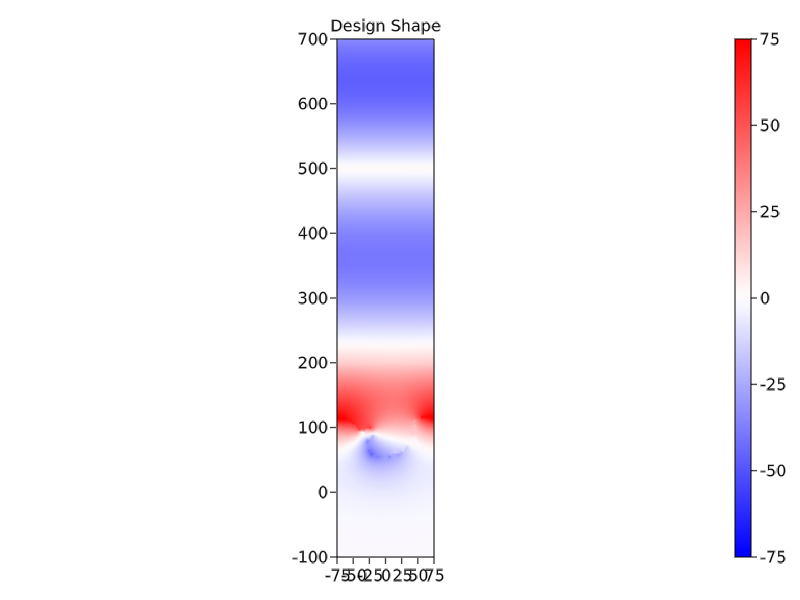

In [22]:
fig, ax, plt = plot(gridap.Ω, real(u1h), colormap = :bwr, colorrange=(-75, 75))
Colorbar(fig[1,2], plt)
ax.aspect = AxisAspect(L/(phys1.LHp[2]+phys1.LHn[2]))
ax.title = "Design Shape"
limits!(ax, -L/2, L/2, -phys1.LHn[2], phys1.LHp[2])
fig

In [18]:
g0_p(zeros(gridap.np), []; kb=0, phys1, phys2, control, gridap)

32986.19196454334

In [19]:
2.14e6/32986

64.87600800339538